In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.bezier as bezier
from scipy.special import comb


In [79]:

class Ray:
    """
    The Ray class defines a ray in 2D space. The ray is launched from the 
    initial position x_init, y_init and the direction is defined by theta.
    """
    courant_number_2D = 1 # courant_number_2d < c_max = 1/sqrt(2) for two dimensions
    velocity = 400
    dx = dy = 1e-6

    def __init__(self, x_init, y_init, theta):
        self.x_init = x_init
        self.y_init = y_init
        self.theta = theta
        self.velocity_x = self.velocity * np.cos(self.theta)
        self.velocity_y = self.velocity * np.sin(self.theta)
        self.dt = Ray.courant_number_2D * min(Ray.dx, Ray.dy) / np.sqrt(self.velocity_x**2 + self.velocity_y**2)


    def next_position(self, grid_vector_field):
        """
        Returns the next position of the ray at time t and updates initial positions.
        Recalculates the time step based on the current velocity.
        Updates velocity based on the grid vector field.
        """
        # update velocity based on grid vector field at current position after scaling down with respect to dx and dy
        self.velocity_x += grid_vector_field[int(self.x_init / Ray.dx), int(self.y_init / Ray.dy), 0] * (Ray.dx)
        self.velocity_y += grid_vector_field[int(self.x_init / Ray.dx), int(self.y_init / Ray.dy), 1] * (Ray.dy)
        
        # print(self.velocity_x, self.velocity_y)

        # calculate time step based on velocity
        self.dt = self.courant_number_2D * min(self.dx, self.dy) / np.sqrt(self.velocity_x**2 + self.velocity_y**2)

        # calculate next position
        x = self.x_init + self.velocity_x * self.dt
        y = self.y_init + self.velocity_y * self.dt

        # update initial position
        self.x_init = x
        self.y_init = y

        return x, y
        

In [83]:


grid_resolution = 100
grid_cell_size = 1e-6
# define grid vector field for 2D space with linear gradient in y direction from 1 to 4 and linear gradient in x direction from 2 to 3
grid_vector_field = np.zeros((grid_resolution, grid_resolution, 2))
grid_vector_field[:, :, 1] = np.linspace(1, 4, grid_resolution).reshape(grid_resolution, 1)
grid_vector_field[:, :, 0] = np.linspace(0, 0, grid_resolution).reshape(1, grid_resolution)



In [84]:
# generate 100 rays from the left edge of the grid and directions and store their paths in a list ray_path_seed
Ray.courant_number_2D = .005

ray_paths_seed = []
for i in range(10):
    ray = Ray(0, grid_cell_size * grid_resolution/2 + i / 1 * grid_cell_size, 0)
    ray_path = np.array([ray.x_init, ray.y_init])
    while ray.x_init < grid_resolution * grid_cell_size and ray.y_init < grid_resolution * grid_cell_size:
        x, y = ray.next_position(grid_vector_field)
        # append new position to ray path
        ray_path = np.vstack((ray_path, np.array([x, y])))
    ray_paths_seed.append(ray_path)

# generate rays from the bottom of the grid and store their paths in a separate list ray_paths_pump
ray_paths_pump = []
for i in range(10):
    ray = Ray(grid_cell_size * grid_resolution/2 + i / 1 * grid_cell_size, 0, np.pi/2)
    ray_path = np.array([ray.x_init, ray.y_init])
    while ray.x_init < grid_resolution * grid_cell_size and ray.y_init < grid_resolution * grid_cell_size:
        x, y = ray.next_position(grid_vector_field)
        # append new position to ray path
        ray_path = np.vstack((ray_path, np.array([x, y])))
    ray_paths_pump.append(ray_path)


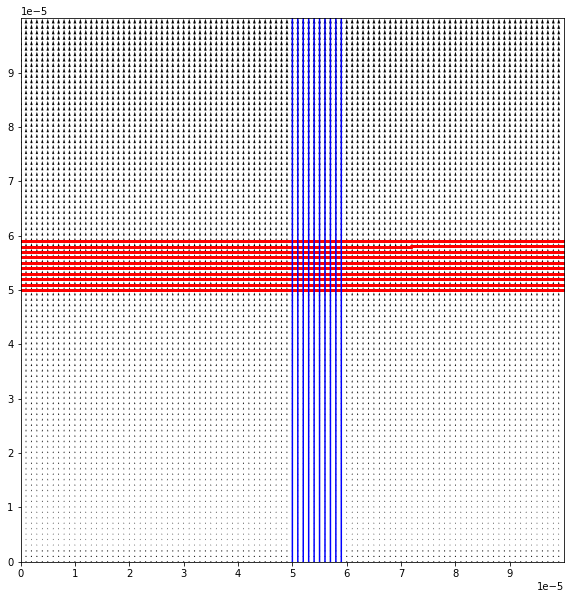

In [85]:

# plot ray path for all rays in the list
fig, ax = plt.subplots()
# figure size larger
fig.set_size_inches(10, 10)
ax.set_aspect('equal')
ax.set_xlim(0, grid_resolution * grid_cell_size)
ax.set_ylim(0, grid_resolution * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size*10))
ax.set_yticks(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size*10))

ax.quiver(np.arange(0, grid_resolution * grid_cell_size, grid_cell_size),
            np.arange(0, grid_resolution * grid_cell_size, grid_cell_size),
            grid_vector_field[:, :, 0], grid_vector_field[:, :, 1], color='k')

for ray_path in ray_paths_seed:
    # ax.plot(ray_path[:, 0], ray_path[:, 1], color='r')
    # scatter all points
    ax.scatter(ray_path[:, 0], ray_path[:, 1], color='r', s=1)

for ray_path in ray_paths_pump:
    ax.plot(ray_path[:, 0], ray_path[:, 1], color='b')

plt.show()




In [8]:
# get size in bytes of the ray paths
import sys
print("Size of ray paths in bytes: ", sys.getsizeof(ray_paths_seed) + sys.getsizeof(ray_paths_pump))


Size of ray paths in bytes:  1840


In [31]:
# redo this whole exercise in 3D space
# define grid vector field for 3D space with linear gradient in z direction from 1 to 4 and linear gradient in x direction from 1 to 2
grid_resolution_3D = 100
grid_vector_field_3D = np.zeros((grid_resolution_3D, grid_resolution_3D, grid_resolution_3D, 3))
grid_vector_field_3D[:, :, :, 2] = np.linspace(1, 4, grid_resolution_3D).reshape(grid_resolution_3D, 1, 1)
grid_vector_field_3D[:, :, :, 0] = np.linspace(1, 2, grid_resolution_3D).reshape(1, grid_resolution_3D, 1)


In [10]:
# redefine ray class for 3D space
class Ray3D:
    courant_number_3D = 0.1
    velocity = 4000
    dx = dy = dz = 1e-6

    def __init__(self, x_init, y_init, z_init, theta, phi):
        self.x_init = x_init
        self.y_init = y_init
        self.z_init = z_init
        self.theta = theta
        self.phi = phi
        self.velocity_x = self.velocity * np.sin(self.theta) * np.cos(self.phi)
        self.velocity_y = self.velocity * np.sin(self.theta) * np.sin(self.phi)
        self.velocity_z = self.velocity * np.cos(self.theta)
        self.dt = Ray3D.courant_number_3D * min(Ray3D.dx, Ray3D.dy, Ray3D.dz) / np.sqrt(self.velocity_x**2 + self.velocity_y**2 + self.velocity_z**2)


    def next_position(self, grid_vector_field):
        """
        Returns the next position of the ray at time t and updates initial positions.
        Recalculates the time step based on the current velocity.
        Updates velocity based on the grid vector field.
        """
        # update velocity based on grid vector field
        self.velocity_x += grid_vector_field[int(self.x_init/self.dx), int(self.y_init/self.dy), int(self.z_init/self.dz), 0]
        self.velocity_y += grid_vector_field[int(self.x_init/self.dx), int(self.y_init/self.dy), int(self.z_init/self.dz), 1]
        self.velocity_z += grid_vector_field[int(self.x_init/self.dx), int(self.y_init/self.dy), int(self.z_init/self.dz), 2]

        # calculate time step based on velocity
        self.dt = self.courant_number_3D * min(self.dx, self.dy, self.dz) / np.sqrt(self.velocity_x**2 + self.velocity_y**2 + self.velocity_z**2)

        # calculate next position
        x = self.x_init + self.velocity_x * self.dt
        y = self.y_init + self.velocity_y * self.dt
        z = self.z_init + self.velocity_z * self.dt

        # update initial position
        self.x_init = x
        self.y_init = y
        self.z_init = z

        return x, y, z
    

In [32]:
# generate initial positions of rays within a disc of radius 10 grid cells in the middle of the xz plane
# and store their paths in a list called ray_paths_seed_3D
ray_paths_seed_3D = []
for i in range(100):
    for j in range(100):
        if(np.sqrt((i - 50)**2 + (j - 50)**2) < 10):
            ray = Ray3D(i * grid_cell_size, 0, j * grid_cell_size, np.pi/2, np.pi/2)
            ray_path = np.array([ray.x_init, ray.y_init, ray.z_init])
            while ray.x_init < grid_resolution_3D * grid_cell_size and ray.y_init < grid_resolution_3D * grid_cell_size and ray.z_init < grid_resolution_3D * grid_cell_size:
                ray_path = np.vstack((ray_path, ray.next_position(grid_vector_field_3D)))
            ray_paths_seed_3D.append(ray_path)

# generate initial positions of rays within a disc of radius 10 grid cells in the middle of the xy plane
# and store their paths in a list called ray_paths_pump_3D
ray_paths_pump_3D = []
for i in range(100):
    for j in range(100):
        if(np.sqrt((i - 50)**2 + (j - 50)**2) < 10):
            ray = Ray3D(i * grid_cell_size, j * grid_cell_size, 0, 0, 0)
            ray_path = np.array([ray.x_init, ray.y_init, ray.z_init])
            while ray.x_init < grid_resolution_3D * grid_cell_size and ray.y_init < grid_resolution_3D * grid_cell_size and ray.z_init < grid_resolution_3D * grid_cell_size:
                ray_path = np.vstack((ray_path, ray.next_position(grid_vector_field_3D)))
            ray_paths_pump_3D.append(ray_path)
            

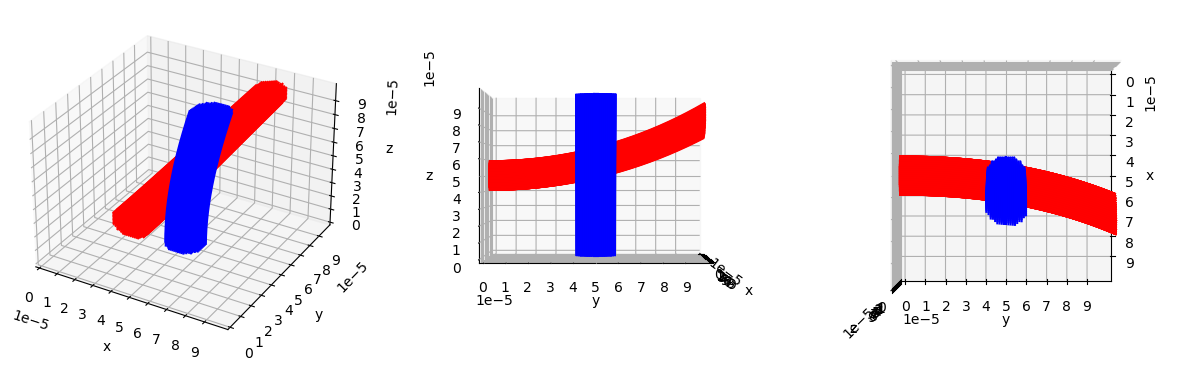

In [40]:
# plot ray path for all rays in the list

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(131, projection='3d')
ax.set_aspect('auto')
ax.set_xlim(0, grid_resolution_3D * grid_cell_size)
ax.set_ylim(0, grid_resolution_3D * grid_cell_size)
ax.set_zlim(0, grid_resolution_3D * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_yticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_zticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
# label axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for ray_path in ray_paths_seed_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='r')

for ray_path in ray_paths_pump_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='b')


ax = fig.add_subplot(132, projection='3d')
ax.set_aspect('auto')
ax.set_xlim(0, grid_resolution_3D * grid_cell_size)
ax.set_ylim(0, grid_resolution_3D * grid_cell_size)
ax.set_zlim(0, grid_resolution_3D * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_yticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_zticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
# label axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for ray_path in ray_paths_seed_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='r')

for ray_path in ray_paths_pump_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='b')

# reposition camera to view the plot from the yz side
ax.view_init(0,0)


ax = fig.add_subplot(133, projection='3d')
ax.set_aspect('auto')
ax.set_xlim(0, grid_resolution_3D * grid_cell_size)
ax.set_ylim(0, grid_resolution_3D * grid_cell_size)
ax.set_zlim(0, grid_resolution_3D * grid_cell_size)
ax.set_xticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_yticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
ax.set_zticks(np.arange(0, grid_resolution_3D * grid_cell_size, grid_cell_size*10))
# label axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for ray_path in ray_paths_seed_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='r')

for ray_path in ray_paths_pump_3D:
    ax.plot(ray_path[:, 0], ray_path[:, 1], ray_path[:, 2], color='b')

# reposition camera to view the plot from the yz side
ax.view_init(90,0)

